In [1]:
import os
import cv2

# from dataset_process import dataset_to_df, search_df
# from engine import train_fn, eval_fn

import numpy as np
# import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
# from torch import Tensor
import torch.nn as nn
# import torch.nn.functional as F

# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.io import read_image

# import albumentations as alb

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# from typing import Optional, Tuple
# import timm
# import wandb
# import time
# from utils import progress_bar
# import csv

In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
start_from_model = False
model_state_path = "../../../weights/vit_cifar10/checkpoint/"
model_file_name = ""

In [4]:
img_size = 32
patch_size = 8
trans_img_resize = 32
image_patch_flat_size = 3*patch_size**2
embed_size = image_patch_flat_size
mlp_dim = 512
train_batch_size = 512
valid_batch_size = 100
num_classes = 10
encoder_depth = 6
attention_heads = 12

print(f'Flattened dimension size(of a patch): {image_patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 192
Embedding Size: 192
Output MLP size: 512


In [5]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.model(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, emb_dropout = 0., dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [6]:
norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [7]:
transform_train = transforms.Compose([
    transforms.RandAugment(2, 14),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(trans_img_resize),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

transform_valid = transforms.Compose([
    transforms.Resize(trans_img_resize),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

In [8]:
# Prepare dataset
train_set = torchvision.datasets.CIFAR10(root='../../../data/CIFAR10', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=NUM_WORKERS )

valid_set = torchvision.datasets.CIFAR10(root='../../../data/CIFAR10', train=False, download=True, transform=transform_valid)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=valid_batch_size, shuffle=False, num_workers=NUM_WORKERS )

Files already downloaded and verified
Files already downloaded and verified


In [9]:
sample_img_batch,label = next(iter(train_loader))

print(f"Batch of Images Shape: {sample_img_batch.size()}")
print(f"Batch of Images Shape: {label.size()}")
print(label)

Batch of Images Shape: torch.Size([512, 3, 32, 32])
Batch of Images Shape: torch.Size([512])
tensor([1, 4, 0, 4, 2, 1, 9, 1, 7, 0, 2, 8, 4, 3, 4, 3, 5, 3, 3, 7, 9, 1, 0, 8,
        8, 7, 7, 7, 6, 4, 1, 0, 8, 1, 4, 6, 5, 1, 6, 4, 8, 0, 5, 0, 6, 1, 8, 1,
        7, 8, 7, 0, 4, 7, 8, 8, 9, 3, 7, 2, 7, 4, 1, 4, 0, 0, 5, 0, 4, 8, 9, 2,
        0, 8, 2, 5, 3, 1, 9, 8, 8, 2, 0, 6, 7, 8, 7, 9, 5, 7, 4, 1, 8, 6, 7, 2,
        3, 2, 3, 3, 7, 0, 6, 8, 5, 6, 0, 4, 9, 6, 6, 8, 0, 0, 7, 4, 2, 9, 2, 4,
        2, 6, 7, 3, 4, 7, 4, 1, 4, 2, 0, 8, 5, 9, 5, 7, 5, 2, 4, 6, 4, 9, 8, 5,
        0, 2, 1, 8, 3, 1, 0, 9, 5, 4, 8, 7, 6, 8, 7, 6, 8, 1, 8, 6, 2, 4, 0, 0,
        0, 3, 5, 6, 9, 3, 2, 6, 2, 7, 6, 2, 2, 4, 2, 7, 0, 4, 9, 9, 8, 0, 1, 7,
        6, 4, 8, 5, 0, 0, 4, 4, 7, 0, 9, 1, 7, 5, 5, 1, 5, 9, 3, 4, 7, 4, 5, 3,
        7, 1, 0, 0, 9, 7, 7, 3, 2, 7, 4, 0, 5, 7, 8, 0, 6, 3, 3, 8, 3, 6, 3, 1,
        5, 2, 8, 2, 8, 8, 7, 0, 9, 0, 9, 8, 5, 4, 4, 2, 4, 2, 4, 6, 8, 8, 0, 0,
        3, 3, 9, 3, 8, 3, 1

In [10]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # c: color channels

        # h: desired slice height (pixels)
        # w: desired slice width (pixels)

        # row: No. of vertical slices
        # col: No. of horizontal slices

        # b: Batch of Images

        sliced_Img = rearrange(
            img, 'c (row h) (col w) -> row col c h w', h=self.slice_width, w=self.slice_width)

        return sliced_Img

    def __call__(self, img):
        sliced_img = self.slice(img)
        sliced_flattened_img = rearrange(
            sliced_img, 'row col c h w -> (row col) (c h w)')

        return sliced_flattened_img

    plt.show()

In [11]:
def img_data(train_loader, index):

    img, label = train_loader.dataset[index]

    channels, img_H, img_W = img.size()
    
    batch = train_loader.batch_size

    return img, label, channels, img_H, batch

In [12]:
def img_plot(img, slice_width):
    slice = SliceImage(slice_width)
    sliced_img = slice.slice(img)
    print("Sliced Image Shape: ", sliced_img.shape)

    fig = plt.figure(layout="constrained", figsize=(8, 4))
    subfigs = fig.subfigures(3, 1, height_ratios=[1., 1.5, 1.], hspace=0.05, squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    img_a = rearrange(img, "c h w -> h w c").numpy()
    
    axs0.imshow(img_a)
    axs0.axis('off')
    # subfigs[0].suptitle('Input Image', fontsize=10)

    grid1 = ImageGrid(subfigs[1], 111, nrows_ncols=(sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid1):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = rearrange(sliced_img[row][column], "c h w -> h w c").numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[1].suptitle('Slices', fontsize=10)

    grid2 = ImageGrid(subfigs[2], 111, nrows_ncols=(1, sliced_img.size(0)*sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid2):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[2].suptitle('Position', fontsize=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Image Shape: torch.Size([3, 32, 32])
Sliced Image Shape:  torch.Size([4, 4, 3, 8, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


slice_embed 192


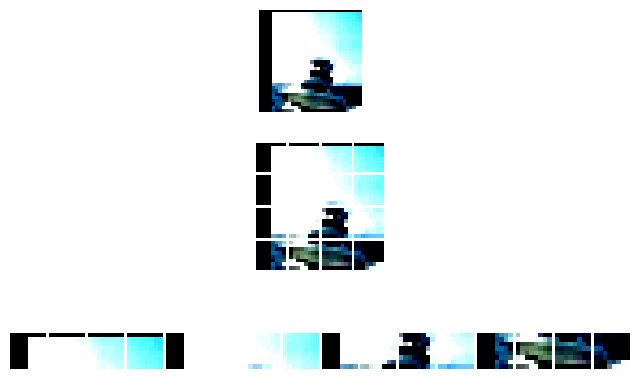

In [13]:
sample_img, _ = train_set[100]
sample_img_tr, sample_img_label, ch, img_size, batch_size = img_data(train_loader, 2)
print(f"Input Image Shape: {sample_img_tr.size()}")
img_plot(sample_img, patch_size)

print("")

slice_embed = embed_size
print("slice_embed", slice_embed)

In [14]:
model = ViT(
    image_size=img_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=slice_embed,
    depth=encoder_depth,
    heads=attention_heads,
    mlp_dim=mlp_dim,
    emb_dropout=0.1,
    dropout=0.1
)


In [15]:
vit_output = model(sample_img_batch)

print("Input Shape: ", sample_img_batch.size())
print("Output Shape: ", vit_output.size())

summary(model=model,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([512, 3, 32, 32])
Output Shape:  torch.Size([512, 10])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [512, 3, 32, 32]     [512, 10]            3,456                True
├─Sequential (to_patch_embedding)                  [512, 3, 32, 32]     [512, 16, 192]       --                   True
│    └─Rearrange (0)                               [512, 3, 32, 32]     [512, 16, 192]       --                   --
│    └─Linear (1)                                  [512, 16, 192]       [512, 16, 192]       37,056               True
├─Dropout (dropout)                                [512, 17, 192]       [512, 17, 192]       --                   --
├─Transformer (transformer)                        [512, 17, 192]       [512, 17, 192]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─ModuleList (0)                     

In [16]:
n_epochs = 100         # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)

In [17]:
if start_from_model:
    checkpoint = torch.load(model_state_path+model_file_name)
    model.load_state_dict(checkpoint['model'])
    
    start_epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    list_tr_loss = checkpoint['list_tr_loss']
    list_tr_acc = checkpoint['list_tr_acc']
    list_val_loss = checkpoint['list_val_loss']
    list_val_acc = checkpoint['list_val_acc']
else:
    start_epoch = 0  
    best_acc = 0

    list_tr_loss = []
    list_tr_acc = []
    list_val_loss = []
    list_val_acc = []

In [18]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=base_lr)
# optimizer = optim.SGD(model.parameters(), lr=base_lr)  
    
# use cosine scheduling
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [19]:
model.to(device)
for epoch in range(start_epoch, n_epochs):

    print(f'\n epoch: {epoch+1}/{n_epochs}')

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path (Gradient)
        loss.backward()
        # Optimizer(Adam) Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total

        loop1.set_description(f"Train--Epoch [{epoch+1}/{n_epochs}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    list_tr_loss.append(avg_tr_loss)
    list_tr_acc.append(avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{n_epochs}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)

    list_val_loss.append(avg_val_loss)
    list_val_acc.append(avg_val_accuracy)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "epoch": epoch,
                 "list_tr_loss": list_tr_loss,
                 "list_tr_acc": list_tr_acc,
                 "list_val_loss": list_val_loss,
                 "list_val_acc": list_val_acc
                 }
        torch.save(state, model_state_path +
                   f'vit_patch{patch_size}_cifar10_epoch_{epoch}')

    ##########################################################

    scheduler.step()  # step cosine scheduling


 epoch: 1/100


Valid--Epoch [1/100]: 100%|██████████| 100/100 [00:01<00:00, 93.69it/s, acc=11.9, loss=2.28]


Saving..

 epoch: 2/100


Valid--Epoch [2/100]: 100%|██████████| 100/100 [00:01<00:00, 94.80it/s, acc=18.9, loss=2.11]


Saving..

 epoch: 3/100


Valid--Epoch [3/100]: 100%|██████████| 100/100 [00:01<00:00, 96.04it/s, acc=21.2, loss=2.08]


Saving..

 epoch: 4/100


Valid--Epoch [4/100]: 100%|██████████| 100/100 [00:01<00:00, 98.42it/s, acc=20.9, loss=2.08]


 epoch: 5/100



Valid--Epoch [5/100]: 100%|██████████| 100/100 [00:01<00:00, 99.32it/s, acc=21.7, loss=2.07]


Saving..

 epoch: 6/100


Valid--Epoch [6/100]: 100%|██████████| 100/100 [00:01<00:00, 97.26it/s, acc=24.3, loss=2.04]


Saving..

 epoch: 7/100


Valid--Epoch [7/100]: 100%|██████████| 100/100 [00:01<00:00, 96.06it/s, acc=23, loss=2.04]  



 epoch: 8/100


Valid--Epoch [8/100]: 100%|██████████| 100/100 [00:01<00:00, 97.93it/s, acc=22.7, loss=2.03]


 epoch: 9/100



Valid--Epoch [9/100]: 100%|██████████| 100/100 [00:00<00:00, 100.33it/s, acc=24, loss=2.02] 



 epoch: 10/100


Valid--Epoch [10/100]: 100%|██████████| 100/100 [00:01<00:00, 97.01it/s, acc=24.3, loss=2.01]



 epoch: 11/100


Valid--Epoch [11/100]: 100%|██████████| 100/100 [00:01<00:00, 97.66it/s, acc=22.6, loss=2.03]


 epoch: 12/100



Valid--Epoch [12/100]: 100%|██████████| 100/100 [00:01<00:00, 95.85it/s, acc=24.9, loss=2]   


Saving..

 epoch: 13/100


Valid--Epoch [13/100]: 100%|██████████| 100/100 [00:01<00:00, 97.41it/s, acc=24.7, loss=2.01]


 epoch: 14/100



Valid--Epoch [14/100]: 100%|██████████| 100/100 [00:01<00:00, 92.96it/s, acc=23.1, loss=2.03]


 epoch: 15/100



Valid--Epoch [15/100]: 100%|██████████| 100/100 [00:01<00:00, 94.75it/s, acc=24.3, loss=2.02]


 epoch: 16/100



Valid--Epoch [16/100]: 100%|██████████| 100/100 [00:01<00:00, 78.51it/s, acc=25, loss=2.01] 


Saving..

 epoch: 17/100


Valid--Epoch [17/100]: 100%|██████████| 100/100 [00:01<00:00, 96.08it/s, acc=23.6, loss=2.02]


 epoch: 18/100



Valid--Epoch [18/100]: 100%|██████████| 100/100 [00:01<00:00, 94.05it/s, acc=23.2, loss=2]   


 epoch: 19/100



Valid--Epoch [19/100]: 100%|██████████| 100/100 [00:01<00:00, 94.00it/s, acc=23.5, loss=2.04]


 epoch: 20/100



Valid--Epoch [20/100]: 100%|██████████| 100/100 [00:01<00:00, 91.59it/s, acc=24.6, loss=2.04] 


 epoch: 21/100



Valid--Epoch [21/100]: 100%|██████████| 100/100 [00:01<00:00, 90.82it/s, acc=22.1, loss=2.06]


 epoch: 22/100



Valid--Epoch [22/100]: 100%|██████████| 100/100 [00:01<00:00, 87.31it/s, acc=22.1, loss=2.07]


 epoch: 23/100



Valid--Epoch [23/100]: 100%|██████████| 100/100 [00:01<00:00, 93.95it/s, acc=24.1, loss=2.03]


 epoch: 24/100



Valid--Epoch [24/100]: 100%|██████████| 100/100 [00:01<00:00, 97.43it/s, acc=25.2, loss=2.01]


Saving..

 epoch: 25/100


Valid--Epoch [25/100]: 100%|██████████| 100/100 [00:01<00:00, 92.65it/s, acc=24.3, loss=2.02]


 epoch: 26/100



Valid--Epoch [26/100]: 100%|██████████| 100/100 [00:01<00:00, 93.41it/s, acc=25, loss=2]    


 epoch: 27/100



Valid--Epoch [27/100]: 100%|██████████| 100/100 [00:01<00:00, 95.05it/s, acc=25.5, loss=2]   


Saving..

 epoch: 28/100


Valid--Epoch [28/100]: 100%|██████████| 100/100 [00:01<00:00, 87.28it/s, acc=17.9, loss=2.17]



 epoch: 29/100


Valid--Epoch [29/100]: 100%|██████████| 100/100 [00:01<00:00, 94.62it/s, acc=23.8, loss=2.04]


 epoch: 30/100



Valid--Epoch [30/100]: 100%|██████████| 100/100 [00:01<00:00, 94.76it/s, acc=24.1, loss=2.01]


 epoch: 31/100



Valid--Epoch [31/100]: 100%|██████████| 100/100 [00:01<00:00, 97.87it/s, acc=24.3, loss=2.02]



 epoch: 32/100


Valid--Epoch [32/100]: 100%|██████████| 100/100 [00:01<00:00, 97.28it/s, acc=24.9, loss=2.01]


 epoch: 33/100



Valid--Epoch [33/100]: 100%|██████████| 100/100 [00:01<00:00, 91.15it/s, acc=23.8, loss=2.04]


 epoch: 34/100



Valid--Epoch [34/100]: 100%|██████████| 100/100 [00:01<00:00, 94.83it/s, acc=25.4, loss=2.01]


 epoch: 35/100



Valid--Epoch [35/100]: 100%|██████████| 100/100 [00:01<00:00, 93.79it/s, acc=23.9, loss=2.02]


 epoch: 36/100



Valid--Epoch [36/100]: 100%|██████████| 100/100 [00:01<00:00, 97.03it/s, acc=24.9, loss=2]   


 epoch: 37/100



Valid--Epoch [37/100]: 100%|██████████| 100/100 [00:01<00:00, 96.88it/s, acc=24, loss=2.02]  



 epoch: 38/100


Valid--Epoch [38/100]: 100%|██████████| 100/100 [00:01<00:00, 96.19it/s, acc=25, loss=1.99]  


 epoch: 39/100



Valid--Epoch [39/100]: 100%|██████████| 100/100 [00:01<00:00, 93.24it/s, acc=23.8, loss=2.02]


 epoch: 40/100



Valid--Epoch [40/100]: 100%|██████████| 100/100 [00:01<00:00, 94.83it/s, acc=24.2, loss=2.01]


 epoch: 41/100



Valid--Epoch [41/100]: 100%|██████████| 100/100 [00:01<00:00, 95.83it/s, acc=25.9, loss=1.99]


Saving..

 epoch: 42/100


Valid--Epoch [42/100]: 100%|██████████| 100/100 [00:01<00:00, 98.00it/s, acc=24.8, loss=2.01]


 epoch: 43/100



Valid--Epoch [43/100]: 100%|██████████| 100/100 [00:01<00:00, 98.21it/s, acc=26.2, loss=1.99]


Saving..

 epoch: 44/100


Valid--Epoch [44/100]: 100%|██████████| 100/100 [00:01<00:00, 96.19it/s, acc=25.9, loss=1.99]



 epoch: 45/100


Valid--Epoch [45/100]: 100%|██████████| 100/100 [00:01<00:00, 87.58it/s, acc=25, loss=2]    


 epoch: 46/100



Valid--Epoch [46/100]: 100%|██████████| 100/100 [00:01<00:00, 91.91it/s, acc=24.8, loss=2]  



 epoch: 47/100


Valid--Epoch [47/100]: 100%|██████████| 100/100 [00:01<00:00, 85.54it/s, acc=24.9, loss=2]  


 epoch: 48/100



Valid--Epoch [48/100]: 100%|██████████| 100/100 [00:01<00:00, 93.00it/s, acc=25.5, loss=2]   



 epoch: 49/100


Valid--Epoch [49/100]: 100%|██████████| 100/100 [00:01<00:00, 93.57it/s, acc=25.3, loss=1.99]


 epoch: 50/100



Valid--Epoch [50/100]: 100%|██████████| 100/100 [00:01<00:00, 96.89it/s, acc=25.4, loss=1.98]



 epoch: 51/100


Valid--Epoch [51/100]: 100%|██████████| 100/100 [00:01<00:00, 94.41it/s, acc=25.4, loss=2]   


 epoch: 52/100



Valid--Epoch [52/100]: 100%|██████████| 100/100 [00:01<00:00, 92.96it/s, acc=25.4, loss=1.99]


 epoch: 53/100



Valid--Epoch [53/100]: 100%|██████████| 100/100 [00:01<00:00, 97.10it/s, acc=25.6, loss=1.99]


 epoch: 54/100



Valid--Epoch [54/100]: 100%|██████████| 100/100 [00:01<00:00, 94.36it/s, acc=25.7, loss=1.98]


 epoch: 55/100



Valid--Epoch [55/100]: 100%|██████████| 100/100 [00:01<00:00, 93.81it/s, acc=25.8, loss=1.98]


 epoch: 56/100



Valid--Epoch [56/100]: 100%|██████████| 100/100 [00:01<00:00, 93.03it/s, acc=26.1, loss=1.99]


 epoch: 57/100



Valid--Epoch [57/100]: 100%|██████████| 100/100 [00:01<00:00, 93.40it/s, acc=26.1, loss=1.98]



 epoch: 58/100


Valid--Epoch [58/100]: 100%|██████████| 100/100 [00:01<00:00, 94.89it/s, acc=25.1, loss=1.98]



 epoch: 59/100


Valid--Epoch [59/100]: 100%|██████████| 100/100 [00:01<00:00, 94.21it/s, acc=24.7, loss=1.99]


 epoch: 60/100



Valid--Epoch [60/100]: 100%|██████████| 100/100 [00:01<00:00, 91.48it/s, acc=26.1, loss=1.97]



 epoch: 61/100


Valid--Epoch [61/100]: 100%|██████████| 100/100 [00:01<00:00, 90.74it/s, acc=26.5, loss=1.96]


Saving..

 epoch: 62/100


Valid--Epoch [62/100]: 100%|██████████| 100/100 [00:01<00:00, 90.49it/s, acc=26.2, loss=1.97]


 epoch: 63/100



Valid--Epoch [63/100]: 100%|██████████| 100/100 [00:01<00:00, 93.30it/s, acc=26.9, loss=1.96]


Saving..

 epoch: 64/100


Valid--Epoch [64/100]: 100%|██████████| 100/100 [00:01<00:00, 88.54it/s, acc=26.2, loss=1.97]


 epoch: 65/100



Valid--Epoch [65/100]: 100%|██████████| 100/100 [00:01<00:00, 90.98it/s, acc=26.9, loss=1.96]


 epoch: 66/100



Valid--Epoch [66/100]: 100%|██████████| 100/100 [00:01<00:00, 96.32it/s, acc=26.8, loss=1.96]


 epoch: 67/100



Valid--Epoch [67/100]: 100%|██████████| 100/100 [00:01<00:00, 96.08it/s, acc=26.3, loss=1.96]


 epoch: 68/100



Valid--Epoch [68/100]: 100%|██████████| 100/100 [00:01<00:00, 98.34it/s, acc=26.8, loss=1.96]



 epoch: 69/100


Valid--Epoch [69/100]: 100%|██████████| 100/100 [00:01<00:00, 93.42it/s, acc=27.3, loss=1.96] 


Saving..

 epoch: 70/100


Valid--Epoch [70/100]: 100%|██████████| 100/100 [00:01<00:00, 94.16it/s, acc=26.3, loss=1.97]


 epoch: 71/100



Valid--Epoch [71/100]: 100%|██████████| 100/100 [00:01<00:00, 94.03it/s, acc=27.1, loss=1.96]


 epoch: 72/100



Valid--Epoch [72/100]: 100%|██████████| 100/100 [00:01<00:00, 93.11it/s, acc=26.7, loss=1.96]


 epoch: 73/100



Valid--Epoch [73/100]: 100%|██████████| 100/100 [00:01<00:00, 95.06it/s, acc=27, loss=1.96]  


 epoch: 74/100



Valid--Epoch [74/100]: 100%|██████████| 100/100 [00:01<00:00, 94.22it/s, acc=27.1, loss=1.96]


 epoch: 75/100



Valid--Epoch [75/100]: 100%|██████████| 100/100 [00:01<00:00, 93.20it/s, acc=26.7, loss=1.96]


 epoch: 76/100



Valid--Epoch [76/100]: 100%|██████████| 100/100 [00:01<00:00, 95.39it/s, acc=27.3, loss=1.95]


 epoch: 77/100



Valid--Epoch [77/100]: 100%|██████████| 100/100 [00:01<00:00, 95.48it/s, acc=26.5, loss=1.96]


 epoch: 78/100



Valid--Epoch [78/100]: 100%|██████████| 100/100 [00:01<00:00, 95.43it/s, acc=26.7, loss=1.96]


 epoch: 79/100



Valid--Epoch [79/100]: 100%|██████████| 100/100 [00:01<00:00, 93.98it/s, acc=27.2, loss=1.95]


 epoch: 80/100



Valid--Epoch [80/100]: 100%|██████████| 100/100 [00:01<00:00, 90.15it/s, acc=26.5, loss=1.96]


 epoch: 81/100



Valid--Epoch [81/100]: 100%|██████████| 100/100 [00:01<00:00, 87.97it/s, acc=26.6, loss=1.96]


 epoch: 82/100



Valid--Epoch [82/100]: 100%|██████████| 100/100 [00:01<00:00, 92.97it/s, acc=26.7, loss=1.96]



 epoch: 83/100


Valid--Epoch [83/100]: 100%|██████████| 100/100 [00:01<00:00, 85.01it/s, acc=26.4, loss=1.96]



 epoch: 84/100


Valid--Epoch [84/100]: 100%|██████████| 100/100 [00:01<00:00, 90.04it/s, acc=26.6, loss=1.96]


 epoch: 85/100



Valid--Epoch [85/100]: 100%|██████████| 100/100 [00:01<00:00, 99.52it/s, acc=26.7, loss=1.95]


 epoch: 86/100



Valid--Epoch [86/100]: 100%|██████████| 100/100 [00:01<00:00, 98.27it/s, acc=26.8, loss=1.95]



 epoch: 87/100


Valid--Epoch [87/100]: 100%|██████████| 100/100 [00:01<00:00, 92.47it/s, acc=26.7, loss=1.95]



 epoch: 88/100


Valid--Epoch [88/100]: 100%|██████████| 100/100 [00:01<00:00, 93.03it/s, acc=26.6, loss=1.95]


 epoch: 89/100



Valid--Epoch [89/100]: 100%|██████████| 100/100 [00:01<00:00, 96.52it/s, acc=27.1, loss=1.95]



 epoch: 90/100


Valid--Epoch [90/100]: 100%|██████████| 100/100 [00:01<00:00, 93.18it/s, acc=26.7, loss=1.95]



 epoch: 91/100


Valid--Epoch [91/100]: 100%|██████████| 100/100 [00:01<00:00, 92.01it/s, acc=27.2, loss=1.95]


 epoch: 92/100



Valid--Epoch [92/100]: 100%|██████████| 100/100 [00:01<00:00, 92.04it/s, acc=26.9, loss=1.95]


 epoch: 93/100



Valid--Epoch [93/100]: 100%|██████████| 100/100 [00:01<00:00, 96.93it/s, acc=26.9, loss=1.95]


 epoch: 94/100



Valid--Epoch [94/100]: 100%|██████████| 100/100 [00:01<00:00, 95.60it/s, acc=26.7, loss=1.95]


 epoch: 95/100



Valid--Epoch [95/100]: 100%|██████████| 100/100 [00:01<00:00, 90.90it/s, acc=27, loss=1.95] 


 epoch: 96/100



Valid--Epoch [96/100]: 100%|██████████| 100/100 [00:01<00:00, 96.40it/s, acc=27, loss=1.95]  


 epoch: 97/100



Valid--Epoch [97/100]: 100%|██████████| 100/100 [00:01<00:00, 95.93it/s, acc=27.1, loss=1.95]


 epoch: 98/100



Valid--Epoch [98/100]: 100%|██████████| 100/100 [00:01<00:00, 93.74it/s, acc=27, loss=1.95]  


 epoch: 99/100



Valid--Epoch [99/100]: 100%|██████████| 100/100 [00:01<00:00, 87.44it/s, acc=26.9, loss=1.95]


 epoch: 100/100



Valid--Epoch [100/100]: 100%|██████████| 100/100 [00:01<00:00, 95.45it/s, acc=26.9, loss=1.95]


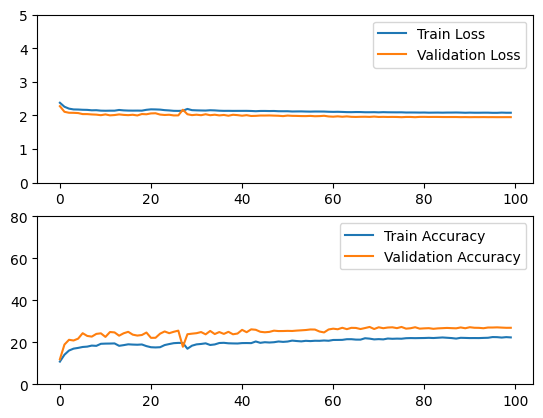

In [20]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(list_tr_loss )), list_tr_loss , label='Train Loss')
axs[0].plot(range(len(list_val_loss)), list_val_loss, label='Validation Loss')
axs[0].set_ylim([0,5])

axs[1].plot(range(len(list_tr_acc)), list_tr_acc, label='Train Accuracy')
axs[1].plot(range(len(list_val_acc)), list_val_acc, label='Validation Accuracy')
axs[1].set_ylim([0,80])

axs[0].legend()
axs[1].legend()
plt.show()